In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from collections import Counter
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, classification_report

In [6]:
# Load the Clean Dataset
df = pd.read_csv('clean_df_3_single_weapon.csv')
df.head()

,Agency Type,Victim Sex,Victim Age,Victim Ethnicity,Perpetrator Sex,Perpetrator Ethnicity,Weapon Category,Relationship Category,Region,Season
0,Other Police,Female,26,Not Hispanic,Male,Not Hispanic,Non-Firearm,Lover,West,Autumn
1,Sheriff,Male,23,Not Hispanic,Male,Not Hispanic,Firearm,Acquaintance,South,Summer
2,Sheriff,Male,42,Not Hispanic,Female,Not Hispanic,Firearm,Lover,South,Summer
3,Sheriff,Male,33,Not Hispanic,Male,Not Hispanic,Firearm,Acquaintance,South,Summer
4,Sheriff,Male,46,Not Hispanic,Male,Not Hispanic,Firearm,Family,South,Autumn


In [8]:
# 1. Apply Label Encoding and Standard Scalarr

categorical_columns = ['Agency Type', 'Victim Sex', 'Victim Age', 'Victim Ethnicity',
       'Perpetrator Sex', 'Perpetrator Ethnicity',
       'Relationship Category', 'Region', 'Season']
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

target_encoder = LabelEncoder()
df["Weapon Category"] = target_encoder.fit_transform(df['Weapon Category']) 

X = df.drop(columns=["Weapon Category"])
y = df["Weapon Category"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
# 3. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

In [10]:
# 4. Compute class weights to handle imbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Class weights: {0: np.float64(0.7452872064474068), 1: np.float64(1.519213368772267)}


In [11]:
# 5. SMOTE Implementation
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)
print("After SMOTE Resampling:", Counter(y_train_resampled))


After SMOTE Resampling: Counter({0: 72091, 1: 72091})


In [49]:
# 6. Train ANN Model with SMOTE and Class weights 

# Encode y_train_resampled
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_resampled) 

# Define the model
model = Sequential([
    Dense(16, input_dim=X_train_resampled.shape[1], activation='relu'),
    BatchNormalization(), 
    Dropout(0.2),
    Dense(8, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_resampled, 
    y_train_encoded, 
    epochs=50, 
    batch_size=32, 
    validation_split=0.2, 
    class_weight=class_weights, 
    callbacks=[early_stopping], 
    verbose=1
)

Epoch 1/50


C:\Users\patbr\PycharmProjects\sandbox\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3605/3605 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.5129 - loss: 0.7232 - val_accuracy: 0.7269 - val_loss: 0.5768
Epoch 2/50
3605/3605 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.5574 - loss: 0.6843 - val_accuracy: 0.7177 - val_loss: 0.5662
Epoch 3/50
3605/3605 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.5689 - loss: 0.6785 - val_accuracy: 0.7597 - val_loss: 0.5539
Epoch 4/50
3605/3605 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.5675 - loss: 0.6750 - val_accuracy: 0.7252 - val_loss: 0.5540
Epoch 5/50
3605/3605 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.5748 - loss: 0.6728 - val_accuracy: 0.7178 - val_loss: 0.5618
Epoch 6/50
3605/3605 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.5784 - loss: 0.6707 - val_accuracy: 0.7621 - val_loss: 0.5463
Epoch 7/50
3605/3605 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.5768 - loss: 0.6694 - val_accuracy: 0.7218 - val_loss: 0.5686
Epoch 8/50
3605/3605 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.5841 - loss: 0.6697 - val

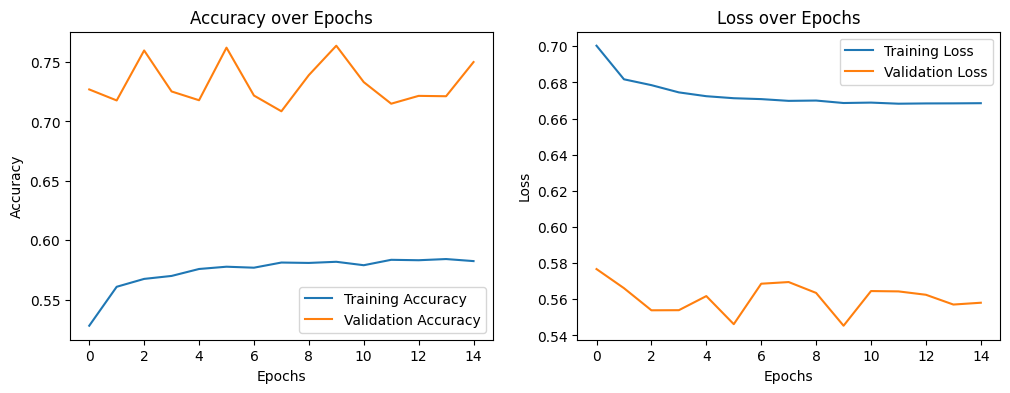

In [50]:
# 7. Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [51]:
# 8. Performance and metrics

y_pred = (model.predict(X_test) > 0.5).astype("int32")

conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
class_report = classification_report(y_test, y_pred)

print('Confusion Matrix')
print(conf_matrix)
print(f'accuracy: {accuracy}')
print(f'recall: {recall}')
print(f'precision: {precision}')
print(f'f1: {f1}')
print(class_report)

1440/1440 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Confusion Matrix
[[14488 16409]
 [ 3638 11519]]
accuracy: 0.5647066487167238
recall: 0.5647066487167238
precision: 0.6719793828378086
f1: 0.5725209680408145
              precision    recall  f1-score   support

           0       0.80      0.47      0.59     30897
           1       0.41      0.76      0.53     15157

    accuracy                           0.56     46054
   macro avg       0.61      0.61      0.56     46054
weighted avg       0.67      0.56      0.57     46054

